In [1]:
import pycountry
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from err_ranges import err_ranges
from sklearn.cluster import KMeans
from scipy.optimize import curve_fit
from sklearn.preprocessing import StandardScaler

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Define a function that reads World Bank data from a CSV file and returns two dataframes:
def read_worldbank_data(filename):
    """
    Function is used to load the data and then it convert it into two formats
    One is year as columns and other is country name as column.
    
    Parameter:
        filename: Name of the data file.
    
    Returns:
        years: Dataframe with years as column
        countries: Dataframe with country names as column
        
    """
    
    # Read the CSV file and skip the first 4 rows
    df = pd.read_csv(filename, skiprows=4)
    
    # Drop unnecessary columns
    df = df.iloc[:, :-1]
    
    # Create a copy of the dataset with years as columns
    years = df.copy()
    
    # Create a dataset with countries as columns
    countries = df.set_index(["Country Name", "Indicator Name"])
    countries.drop(["Country Code", "Indicator Code"], axis=1, inplace=True)
    
    # Transpose the countries dataframe
    countries = countries.T
    
    # Return the years and countries dataframes
    return years, countries


df, countries = read_worldbank_data("dataset.csv")

In [3]:
# Function to filter the data
def filter_data(df, indicators):
    """
    Function is used to extract specific data from the dataframe
    
    Parameters:
        df: Total Dataframe
        indicators: The indicators for which data has to be extracted.
        
    Returns:
        filtered_df: Extracted data
    """
    
    # Filter the dataset for the required indicators
    filtered_df = df[df["Indicator Name"].isin(indicators)]
    
    # Extracting data for only countries
    country_names = [country.name for country in list(pycountry.countries)]
    filtered_df = filtered_df[filtered_df["Country Name"].isin(country_names)]
    
    return filtered_df

In [4]:
indicators = [
    'Agricultural land (% of land area)',
    'Forest area (% of land area)',
    'CO2 emissions (metric tons per capita)',
    'Methane emissions (kt of CO2 equivalent)',
    'Nitrous oxide emissions (thousand metric tons of CO2 equivalent)',
    'Total greenhouse gas emissions (kt of CO2 equivalent)',
    'Renewable electricity output (% of total electricity output)'
    'Renewable energy consumption (% of total final energy consumption)',
]

filtered_df = filter_data(df, indicators)

In [5]:
# Handle missing values
filtered_df = filtered_df.fillna(method='ffill').fillna(method='bfill')

In [6]:
# Pivot the dataframe
pivot_df = filtered_df.pivot_table(index='Country Name', columns='Indicator Name', values='2020')

In [7]:
labels = ["Agricultural land", "Forest area", "CO2 emissions", "Methane emissions", "Nitrous oxide emissions", 
          "Total greenhouse gas emissions", "Renewable electricity output", "Renewable energy consumption"]

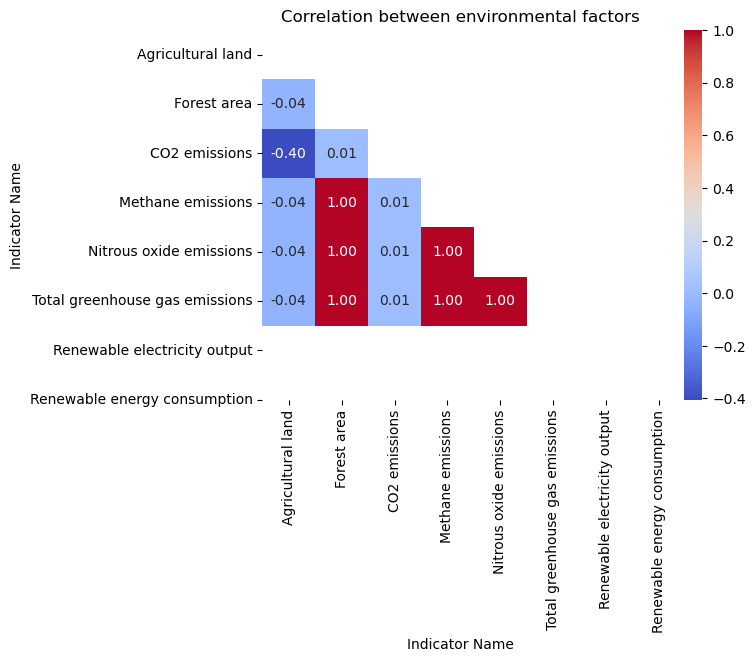

In [8]:
# Correlation
corr = pivot_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.title('Correlation between environmental factors')
plt.show()

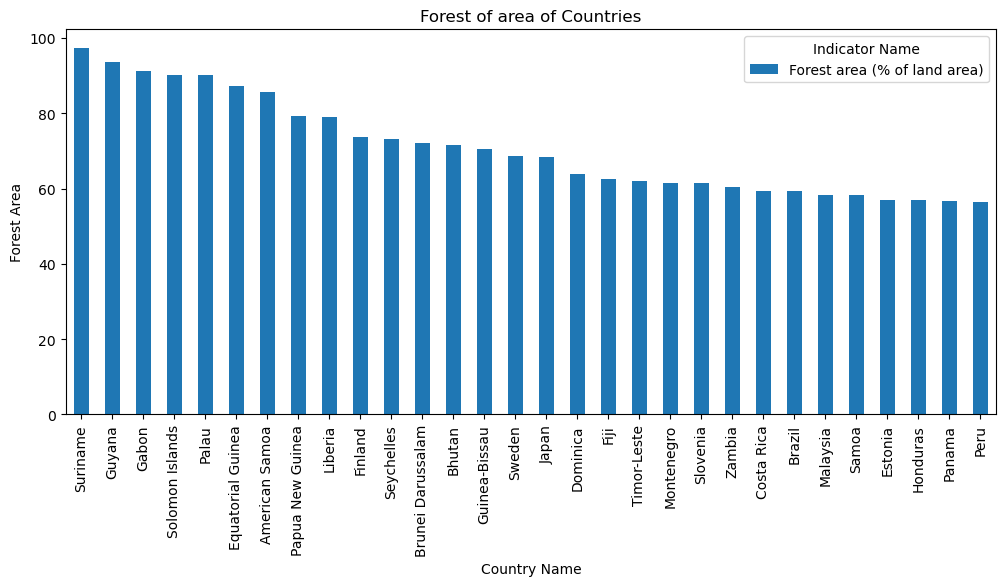

In [9]:
# Ploting Highest Forest area Countries
temp = pivot_df[["Forest area (% of land area)"]].sort_values(by="Forest area (% of land area)", ascending=False).iloc[:30]
temp.plot(kind="bar", figsize=(12, 5))
plt.ylabel("Forest Area")
plt.title("Forest of area of Countries")
plt.show()

## Clustering

In [10]:
# Normalize the dataset
scaler = StandardScaler()
normalized_data = scaler.fit_transform(pivot_df.values)

In [11]:
# Choose the number of clusters
n_clusters = 3

# Perform clustering using KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
labels = kmeans.fit_predict(normalized_data)

# Add the cluster labels to the dataset
pivot_df["Cluster"] = labels

C:\Users\autom\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\autom\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


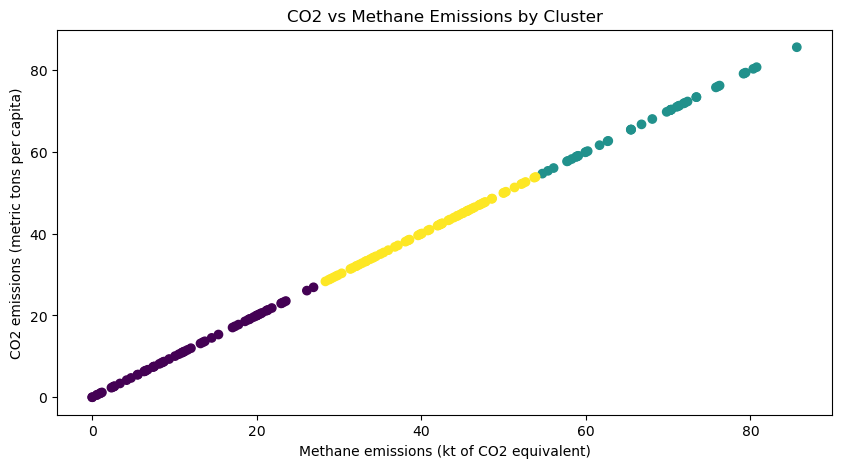

In [12]:
# Create a scatter plot with the specified columns and labels
plt.figure(figsize=(10, 5))
plt.scatter(pivot_df['Methane emissions (kt of CO2 equivalent)'],
            pivot_df['CO2 emissions (metric tons per capita)'],
            c=pivot_df['Cluster'])

# Add axis labels and a title to the plot
plt.xlabel('Methane emissions (kt of CO2 equivalent)')
plt.ylabel('CO2 emissions (metric tons per capita)')
plt.title('CO2 vs Methane Emissions by Cluster')

# Show the plot
plt.show()

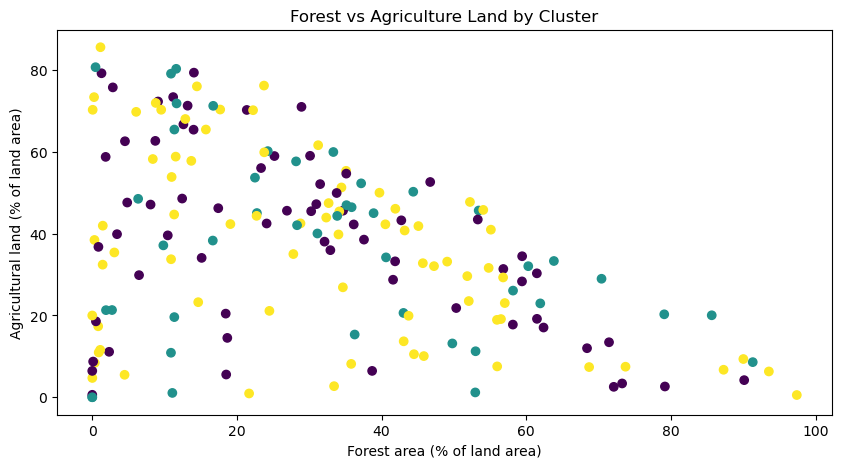

In [13]:
# Create a scatter plot with the specified columns and labels
plt.figure(figsize=(10, 5))
plt.scatter(pivot_df['Forest area (% of land area)'],
            pivot_df['Agricultural land (% of land area)'],
            c=pivot_df['Cluster'])

# Add axis labels and a title to the plot
plt.xlabel('Forest area (% of land area)')
plt.ylabel('Agricultural land (% of land area)')
plt.title('Forest vs Agriculture Land by Cluster')

# Show the plot
plt.show()

In [14]:
pivot_df.groupby("Cluster").mean()

Indicator Name,Agricultural land (% of land area),CO2 emissions (metric tons per capita),Forest area (% of land area),Methane emissions (kt of CO2 equivalent),Nitrous oxide emissions (thousand metric tons of CO2 equivalent),Total greenhouse gas emissions (kt of CO2 equivalent)
Cluster,,,,,,
0,38.831199,12.125344,29.770579,12.125344,12.125344,12.125344
1,36.939702,67.844772,32.933578,67.844772,67.844772,67.844772
2,36.621152,41.048969,31.274387,41.048969,41.048969,41.048969


In [25]:
labels = ["Agricultural land", "Forest area", "CO2 emissions", "Methane emissions", "Nitrous oxide emissions", 
          "Total greenhouse gas emissions", "Renewable electricity output", "Renewable energy consumption"]

In [31]:
temp = pivot_df.groupby("Cluster").mean().T
temp.index = labels[:6]

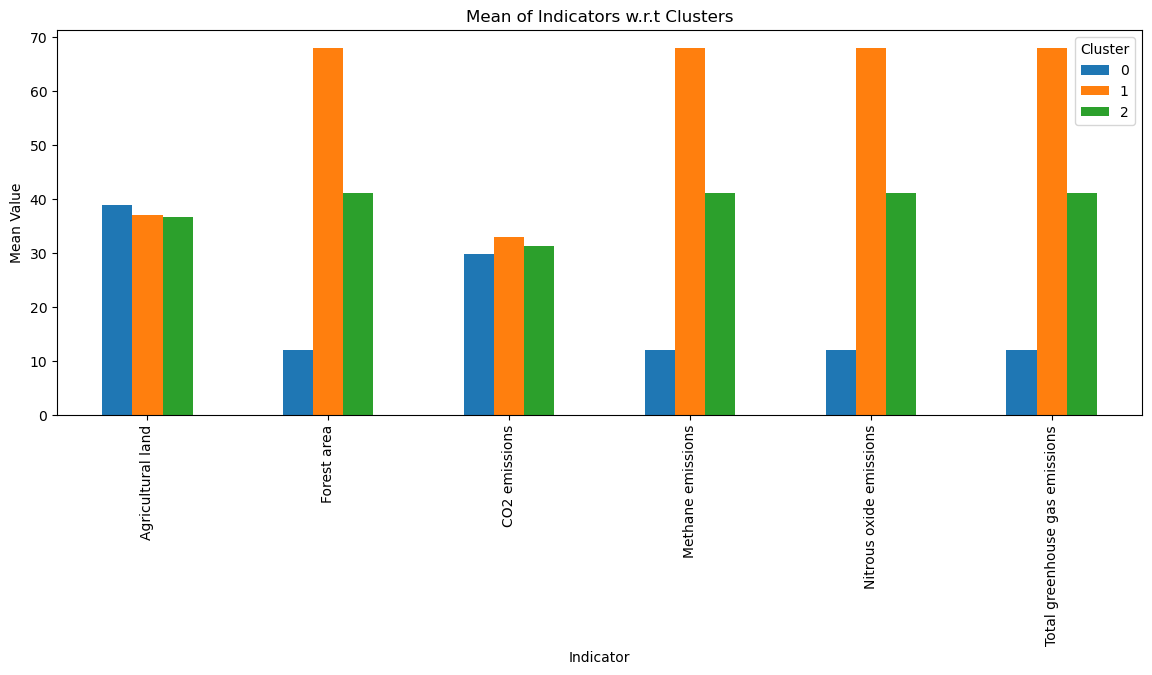

In [34]:
temp.plot(kind="bar", figsize=(14, 5))
plt.title("Mean of Indicators w.r.t Clusters")
plt.ylabel("Mean Value")
plt.xlabel("Indicator")
plt.show()

In [16]:
# Selecting one country from each cluster
pivot_df.groupby("Cluster").last()

Indicator Name,Agricultural land (% of land area),CO2 emissions (metric tons per capita),Forest area (% of land area),Methane emissions (kt of CO2 equivalent),Nitrous oxide emissions (thousand metric tons of CO2 equivalent),Total greenhouse gas emissions (kt of CO2 equivalent)
Cluster,,,,,,
0,71.340049,8.587108,13.185632,8.587108,8.587108,8.587108
1,32.063923,79.417850,60.283337,79.417850,79.417850,79.417850
2,41.876696,32.063923,45.093912,32.063923,32.063923,32.063923


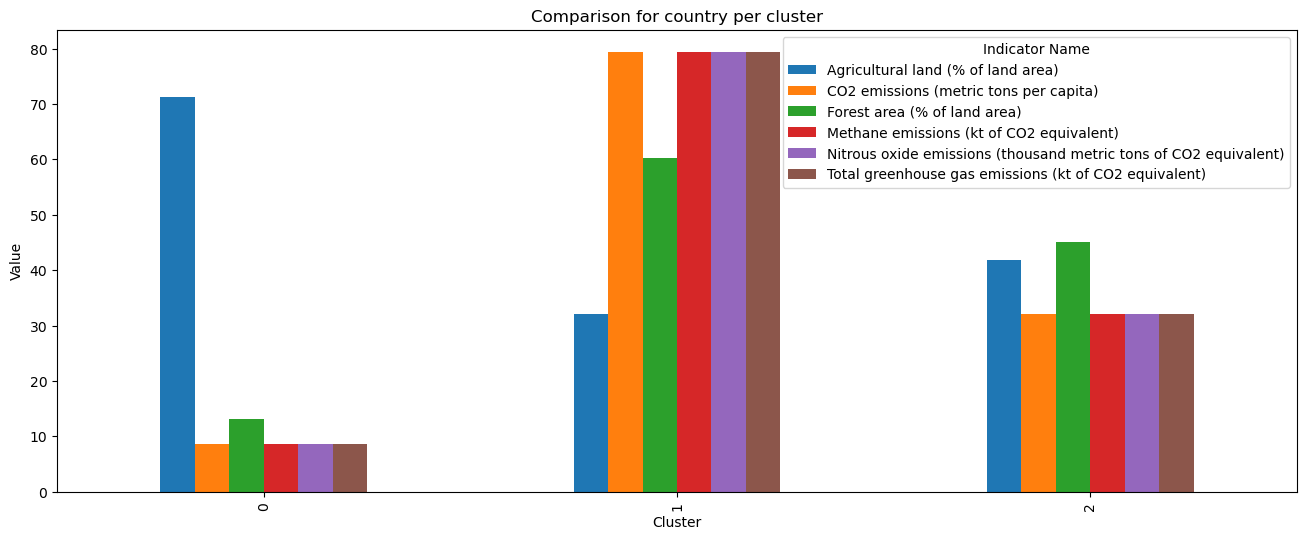

In [17]:
# Comapring values for each country
pivot_df.groupby("Cluster").last().plot(kind="bar", figsize=(16, 6))
plt.title("Comparison for country per cluster")
plt.ylabel("Value")
plt.show()

## Series Model

In [18]:
def linear_func(x, a, b):
    """
    Computes the linear function y = a*x + b.

    Parameters
    ----------
    x : float or array-like
        The input value(s) for the function.
    a : float
        The slope of the linear function.
    b : float
        The y-intercept of the linear function.

    Returns
    -------
    float or array-like
        The output value(s) of the linear function.
    """
    return a*x + b

In [19]:
def model_data(x_data, y_data, linear_func, sigma=[1.0, 1.0]):
    """
    Fits a given model function to the provided data, generates predictions for
    future years, estimates confidence intervals, and plots the results.

    Parameters
    ----------
    x_data : array-like
        The x values (independent variable) for the data to be fit.
    y_data : array-like
        The y values (dependent variable) for the data to be fit.
    linear_func : callable
        A function that represents the model to be fit to the data.
    sigma : list, optional
        A list containing the number of standard deviations for the confidence
        intervals to be computed. The first element represents the sigma value
        for the model parameters, and the second element represents the sigma
        value for the predicted values. Defaults to [1.0, 1.0].

    Returns
    -------
    None
        The function generates a plot of the fitted function, predicted values,
        and confidence intervals.

    """
    
    # perform the curve fit
    popt, pcov = curve_fit(linear_func, x_data, y_data)
    
    # define an array of x values representing future years
    x_pred = np.arange(2022, 2042)

    # generate y values for the predicted years using the model function
    y_pred = linear_func(x_pred, *popt)
    
    # generate lower and upper limits for the predicted values using err_ranges
    lower, upper = err_ranges(x_pred, linear_func, popt, sigma)
    
    print(f"Predictions are...")
    print(y_pred)
    
    # plot the model function and the confidence intervals for the predictions
    plt.figure(figsize=(12, 5))
    plt.plot(x_data, y_data, 'bo', label='Data')
    plt.plot(x_pred, y_pred, 'r-', label='Linear Fit')
    plt.fill_between(x_pred, lower, upper, color='green', alpha=0.2, label='Confidence Interval')
    plt.legend(loc='best')
    plt.title("Population Prediction with Simple Model")
    plt.xlabel('Year')
    plt.ylabel('Total Population')
    plt.show()

Predictions are...
[7.94235125e+09 8.02411791e+09 8.10588457e+09 8.18765122e+09
 8.26941788e+09 8.35118454e+09 8.43295119e+09 8.51471785e+09
 8.59648451e+09 8.67825116e+09 8.76001782e+09 8.84178448e+09
 8.92355114e+09 9.00531779e+09 9.08708445e+09 9.16885111e+09
 9.25061776e+09 9.33238442e+09 9.41415108e+09 9.49591773e+09]


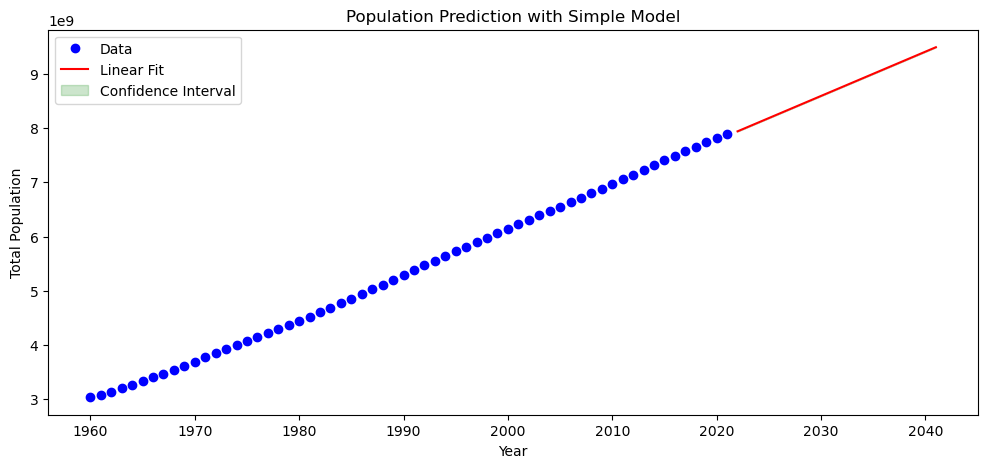

In [20]:
# extract the data we want to fit the model to
data = countries[("World", "Population, total")]

X = data.index.astype("int")
y = data.values.astype("float64")

model_data(X, y, linear_func)